In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import umap
%matplotlib inline

In [2]:
#ml imports
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [3]:
df = pd.read_csv('.\\data\\train.csv')

In [4]:
df_test = pd.read_csv('.\\data\\test.csv')

In [5]:
file = open('.//data/data_description.txt', 'r')

In [6]:
with open('.//data/data_description.txt') as file:
    text_data = file.readlines()
for temp in text_data:
    print(temp.strip())

MSSubClass: Identifies the type of dwelling involved in the sale.

20	1-STORY 1946 & NEWER ALL STYLES
30	1-STORY 1945 & OLDER
40	1-STORY W/FINISHED ATTIC ALL AGES
45	1-1/2 STORY - UNFINISHED ALL AGES
50	1-1/2 STORY FINISHED ALL AGES
60	2-STORY 1946 & NEWER
70	2-STORY 1945 & OLDER
75	2-1/2 STORY ALL AGES
80	SPLIT OR MULTI-LEVEL
85	SPLIT FOYER
90	DUPLEX - ALL STYLES AND AGES
120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150	1-1/2 STORY PUD - ALL AGES
160	2-STORY PUD - 1946 & NEWER
180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.

A	Agriculture
C	Commercial
FV	Floating Village Residential
I	Industrial
RH	Residential High Density
RL	Residential Low Density
RP	Residential Low Density Park
RM	Residential Medium Density

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property

Grvl	Gravel
Pave	Pave

In [7]:
#similar sounding column names to later compare/columns to possibly combine to avoid collinearity:
#Condition1, Condition2
#OverallQual, OverallCond
#YearBuilt,YearRemodAdd
#Exterior1st, Exterior2nd
#ExterQual, ExterCond
#BsmtFinSF1, BsmtFinType2, BsmntUnfSF, TotalBsmtSF
#BsmtFullBath, BsmtHalfBath
#FullBath, HalfBath
#All of the number and quality columns
#GarageCars, GarageArea
#GarageQual, GarageCond
#WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch
#MiscFeature, MiscVal

# Data Exploration
The label is the SalePrice column

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


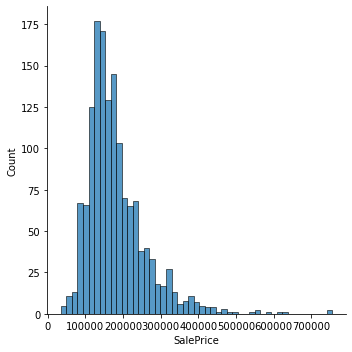

In [10]:
#Distribution plot of label, appears to be normally distributed
sns.displot(data=df,x='SalePrice')

In [11]:
#Correlation with label
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [12]:
#check value_counts() of dimensions

OverallQual column: Rates the overal material and finish of the house
GrLivArea: Above grade (ground) living area square feet
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet


<AxesSubplot:>

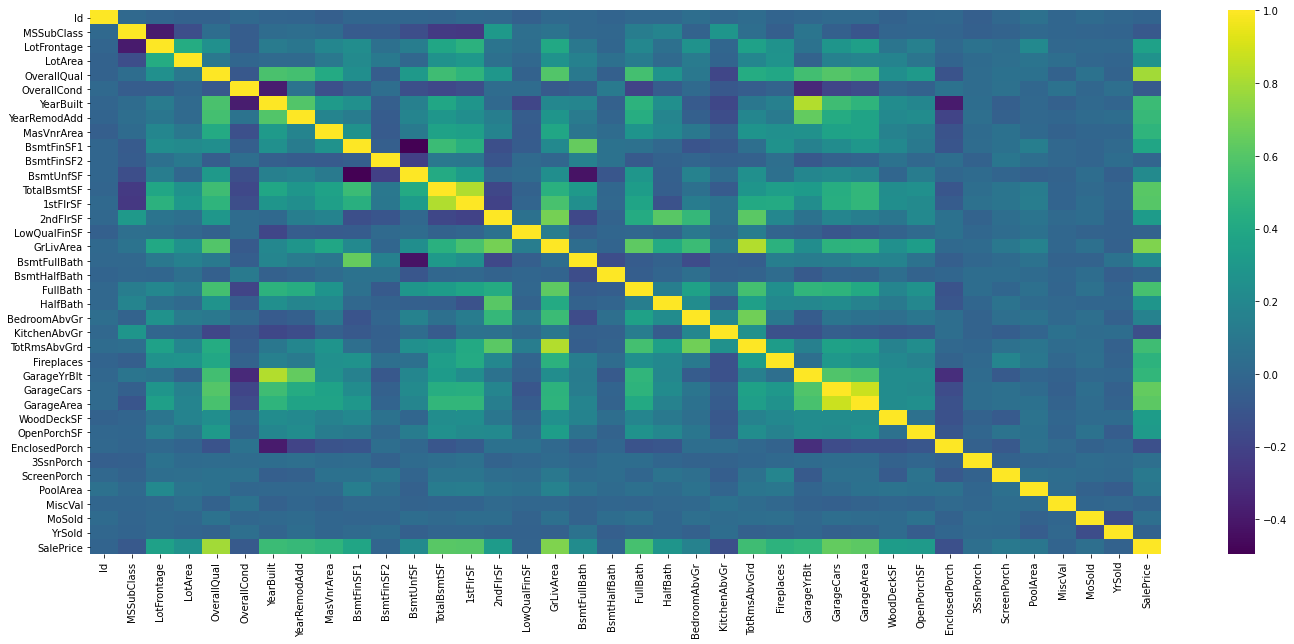

In [13]:
plt.figure(figsize=(24,10))
sns.heatmap(data=df.corr(),cmap='viridis')

We can try predicting based on a manual selection on some of these dimensions or we can use Principal Component Analysis to reduce the dimensionality of this data set and eliminate multicollinearity among the predictor variables. We'll try reducing the dimensions first

<AxesSubplot:>

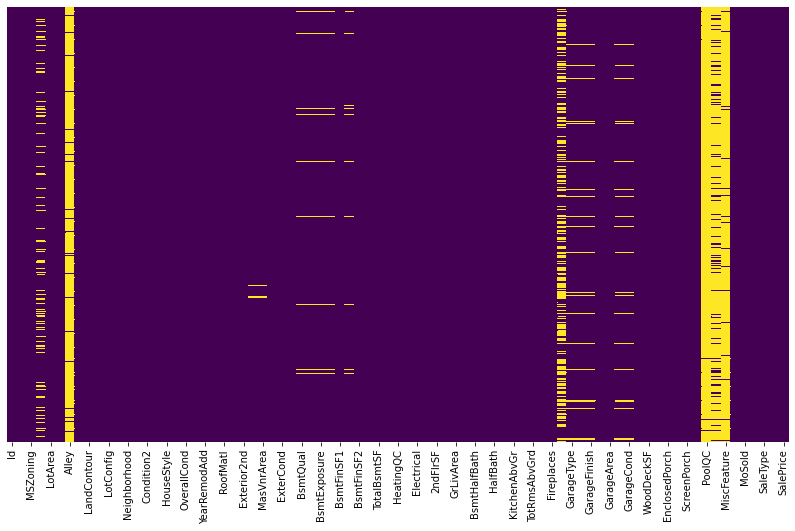

In [14]:
#Alley, PoolQC, Fence, MiscFeature are mostly empty. We can turn them into binary labels,
#or drop them completely.
plt.figure(figsize=(14,8))
sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [15]:
#Alley
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [16]:
df['Alley'] = df['Alley'].fillna(value='None')

In [17]:
#PoolQC, only 7 values so I will drop
df['PoolQC'].value_counts()

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

In [18]:
df.drop(columns='PoolQC',axis=1,inplace=True)

In [19]:
#Fence
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [20]:
#fillna for fence
df['Fence'] = df['Fence'].fillna(value='None')

In [21]:
#MiscFeature, less than 5 percent are filled, and shed does not seem like it would matter 
#while the value of the tennis court house likely has other dimensions that will account for it
df['MiscFeature'].value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [22]:
df.drop(columns='MiscFeature',axis=1,inplace=True)

In [23]:
#Fireplaces is probably good enough without the fireplace quality column so we will drop it
df['Fireplaces'].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [24]:
df.drop(columns='FireplaceQu',axis=1,inplace=True)

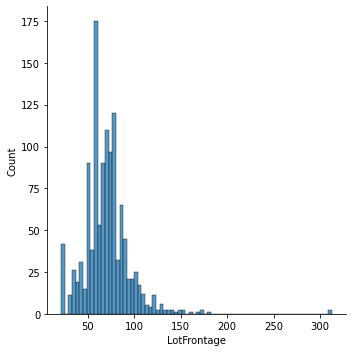

In [25]:
#LotFrontage
sns.displot(data=df,x='LotFrontage')

In [26]:
#fillna of LotFrontage, replace with 0
df['LotFrontage'] = df['LotFrontage'].fillna(value=0)

In [27]:
#

In [28]:
df.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [29]:
#First get dummies from text columns
df = pd.get_dummies(data=df,columns=['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'], drop_first=True)

In [30]:
df.drop(labels='Id',axis=1,inplace=True)

In [31]:
#quick drop of remaining NA rows, they represent less than 10% of data
df.dropna(inplace=True)

In [32]:
#remove label and Id column from PCA
df_pca = df.drop(labels='SalePrice',axis=1)

In [33]:
#standardize, fit, transform data
scaler = StandardScaler()

In [34]:
x_pca = scaler.fit_transform(df_pca)

In [35]:
#PCA with 20 components, roughly 10% of the original number of dimensions
pca = PCA(n_components=50)

In [36]:
pca.fit(x_pca)

PCA(n_components=50)

In [37]:
#transform into 20 principal components
x_pca = pca.transform(x_pca)

In [38]:
x_pca.shape

(1371, 50)

In [39]:
pca.components_

array([[ 0.0064638 ,  0.03808682,  0.02662353, ..., -0.01241548,
        -0.06088888,  0.11203028],
       [ 0.11850124, -0.0010886 , -0.105513  , ..., -0.00284298,
        -0.03971869,  0.06005934],
       [-0.02795493,  0.09745339,  0.18199539, ...,  0.01128462,
        -0.02164769,  0.01309436],
       ...,
       [-0.04296115, -0.05223985, -0.01248535, ...,  0.00831088,
        -0.04016321,  0.0211468 ],
       [ 0.03293297, -0.00958795, -0.02756925, ..., -0.00889898,
        -0.04012126,  0.01534466],
       [ 0.09908624,  0.10181072, -0.04604986, ..., -0.01815506,
        -0.00385368, -0.01368898]])

In [40]:
x_pca = pd.DataFrame(pca.components_,columns=df_pca.columns)

<AxesSubplot:>

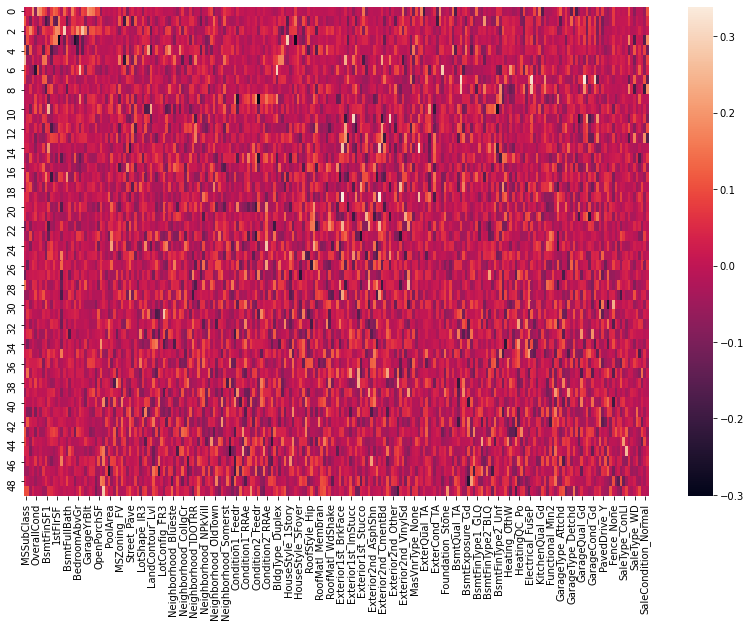

In [41]:
plt.figure(figsize=(14,9))
sns.heatmap(x_pca)

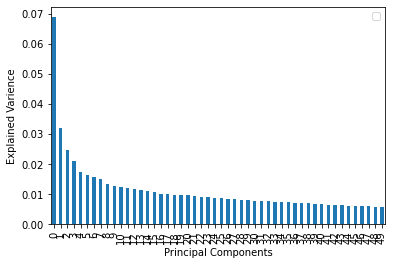

In [42]:
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()
plt.legend('')
plt.xlabel('Principal Components')
plt.ylabel('Explained Varience');

In [43]:
#
#We can run build a simple prediction model on this first component and check our results 
pca.explained_variance_ratio_[0]
#x_pca[:1].stack().sort_values(ascending=False)

0.06888435769007314

The explained variance by the first principal vector is very low, so I will try to select features based on feature importance using a random forest regressor

In [44]:
rf = RandomForestRegressor(max_depth=20)

In [52]:
#need train test split, or a seperate variable to fit transform the label but not fit it
X = df.drop(labels='SalePrice',axis=1)
y = df['SalePrice']
X_df = scaler.fit_transform(df.drop(labels='SalePrice',axis=1))

In [53]:
rf.fit(X_df,y)

RandomForestRegressor(max_depth=20)

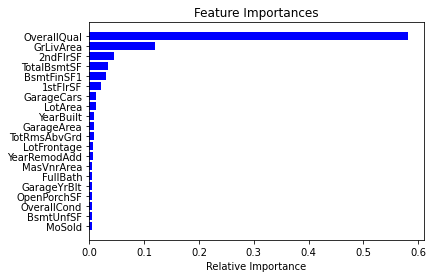

In [54]:
features = df.drop(labels='SalePrice',axis=1).columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [55]:
np.corrcoef(x=df['OverallQual'],y=df['GrLivArea'])

array([[1.        , 0.59123769],
       [0.59123769, 1.        ]])

In [56]:
features = SelectFromModel(rf)

In [57]:
Fit = features.fit_transform(X_df,y)

In [62]:
print(Fit)

[[ 0.20624289 -0.21883609  0.6096228  ...  0.21560696 -1.60895833
   1.1420165 ]
 [ 0.63470891 -0.10632348 -0.1346273  ... -0.72343197 -0.49431363
   1.1420165 ]
 [ 0.2919361   0.05510767  0.6096228  ... -0.07688058  0.99187932
   1.1420165 ]
 ...
 [ 0.23480729 -0.16091655  0.6096228  ...  0.20021288 -0.49431363
  -0.87564409]
 [ 0.2919361  -0.09487654 -0.8788774  ... -0.72343197 -0.86586186
  -0.87564409]
 [ 0.4918869  -0.07335239 -0.8788774  ...  0.32336552 -0.12276539
  -0.87564409]]
